# General data reader for AQUA 
## Spatial regridding

The reader includes also regridding functionality. The idea of the regridder (which uses sparse matrix multiplication) is to generate first the weights for the interpolation (an operation which needs to be done only once) and then to use them for each regridding operation.

The regridding weights are generated automatically by the reader if not already existant and stored in a directory specified in a machine-specific `config/machines/<machine-name>/regrid.yaml` file, where `<machine-name>` is the name of the current machine (e.g. "levante"). The same file also contains a list of predefined target grids (only regular lon-lat for now). For example "r100" is a regular grid at 1° resolution. New target grids can be defined in `regrid.yaml`. Since CDO is used to generate the weights, also a sample target file could be used. The precomputed weights are stored in a directory also specified in the `regrid.yaml` configuration file for each machine. This directory could be shared among the members of a research group in order to reduce the need to recompute the weights.

3D weights are particularly expensive in termso of computation and memory. We suggest to run the first instance of the weights generation process (the first time you initialize the Reader for a data source and a specific target grid) on a dedicated computing node. For example, if `nproc=16` computing cores are used (the default - this spawns 16 parallel cdo processes) for FESOM NG5 data, up to about 170 GB of memory will be needed and the calculation will last about 10 minutes. This will need to be done only once, to precompute the weights.

CDO is used for generating the weights and it will be needed in your environment. CDO is not needed to use the regridder, only to generate the weights. The regridder configuration file also stores for now (this may be modified in the future) information on files containing a grid description for different data sources. A fixed path to the CDO executable for each machine can be specified in the `config/config.yaml` file. If not specified the system `$PATH` will be used.

For regridding to work you will need the external [smmregrid](https://github.com/jhardenberg/smmregrid) module.

In [1]:
from aqua import Reader

### Example 1: IFS

We load IFS data specifying that we wish to regrid them to a 2° grid.

In [2]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", regrid="r200", fix=False)
data = reader.retrieve()

by default, the data are still on the raw original grid. Let's look at temperature

In [3]:
data["2t"][1,:]

<xarray.DataArray '2t' (value: 26306560)>
dask.array<getitem, shape=(26306560,), dtype=float64, chunksize=(26306560,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    time     datetime64[ns] 2020-01-20T01:00:00
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               3.4028234663852886e+38
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

... but we can now ask to regrid it (or part of it) to the destination grid which we chose when we instantiated the reader.

In [4]:
tasr = reader.regrid(data["2t"][0:3,:])

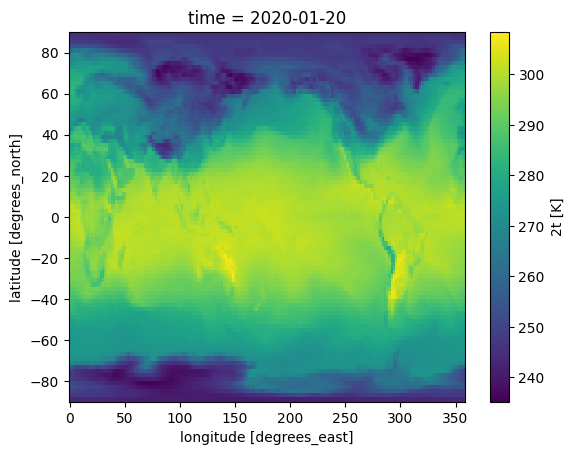

In [5]:
tasr[0,:,:].plot()

### Example 2: ICON

Instantiate a reader for ICON data specifying that we will want to interpolate to a 2 deg grid (the grids are defined in the `regrid.yaml` file and the weights saved in a special directory). If the weights file does not already exist in our collection it will be created automatically.

In [6]:
from aqua import Reader, catalogue
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid="r200")

Load the actual data. By default these data have not been regridded yet. 

In [7]:
data = reader.retrieve()

2023-11-30 16:04:02 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-11-30 16:04:02 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-11-30 16:04:02 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-30 16:04:02 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-11-30 16:04:02 :: Reader :: ERROR    -> Variable cfh_lnd has no units!


By default these data have not been regridded yet

In [8]:
data

<xarray.Dataset>
Dimensions:   (time: 37009, cell: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Dimensions without coordinates: cell
Data variables: (12/33)
    cfh_lnd   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tciw      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tclw      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cptgzvi   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mslhfl    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msshfl    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ...        ...
    10u       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    10v       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msntrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mtntrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    msnsrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    mtnsrf    (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 1522142023-11-30 16:04:02 retrie...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

Now we actually regrid part of the data (the first 96 frames)

In [9]:
tasr = reader.regrid(data['2t'][1:100,:]) 

In [10]:
tasr

<xarray.DataArray '2t' (time: 99, lat: 90, lon: 180)>
dask.array<reshape, shape=(99, 90, 180), dtype=float64, chunksize=(6, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T00:30:00 ... 2020-01-22T01:30:00
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes:
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    2 metre temperature
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K
    history:                      2023-11-30 16:04:02 variable renamed by AQU...
    paramId:                      167
    cfVarName:                    t2m
    shortName:                    2t
    regridded:                    1

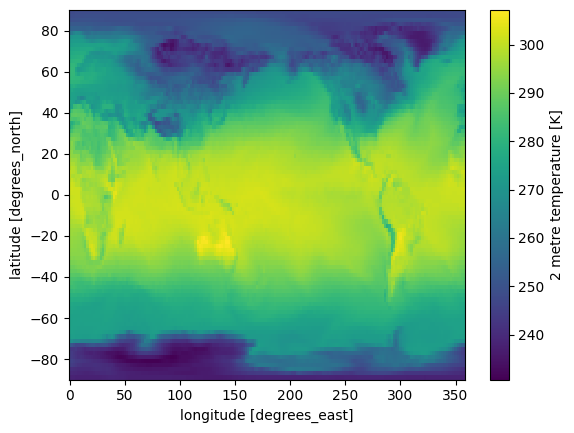

In [11]:
tasr.mean("time").plot()

### Example 3: Original 2D FESOM data - further interpolation

In [12]:
from aqua import Reader
reader = Reader(model="FESOM", exp="tco2559-ng5-cycle3", source="2D_daily_native", regrid="r250")

In [13]:
data = reader.retrieve()

2023-11-30 16:05:29 :: eccodes :: WARNING  -> ShortName sst have multiple grib codes associated: ['34', '151159']
2023-11-30 16:05:29 :: eccodes :: WARNING  -> AQUA will take the first so that sst -> 34, please set up a correct fix if this does not look right
2023-11-30 16:05:29 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-30 16:05:29 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-11-30 16:05:29 :: eccodes :: WARNING  -> ShortName wo have multiple grib codes associated: ['262507', '151133']
2023-11-30 16:05:29 :: eccodes :: WARNING  -> AQUA will take the first so that wo -> 262507, please set up a correct fix if this does not look right
2023-11-30 16:05:29 :: eccodes :: WARNING  -> ShortName so have multiple grib codes associated: ['262500', '151130']
2023-11-30 16:05:29 :: eccodes :: WARNING  -> AQUA will take the first so that so -> 262500, p

In [14]:
sst0=data.zos.isel(time=0)

In [15]:
sst0

<xarray.DataArray 'zos' (nod2: 7402886)>
dask.array<getitem, shape=(7402886,), dtype=float32, chunksize=(7402886,), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-20T23:56:00
Dimensions without coordinates: nod2
Attributes:
    description:  sea surface elevation
    long_name:    Sea surface height
    units:        m
    history:      2023-11-30 16:05:29 variable renamed by AQUA fixer;\n
    paramId:      262124
    cfVarName:    zos
    shortName:    zos

In [16]:
sstr = reader.regrid(sst0)

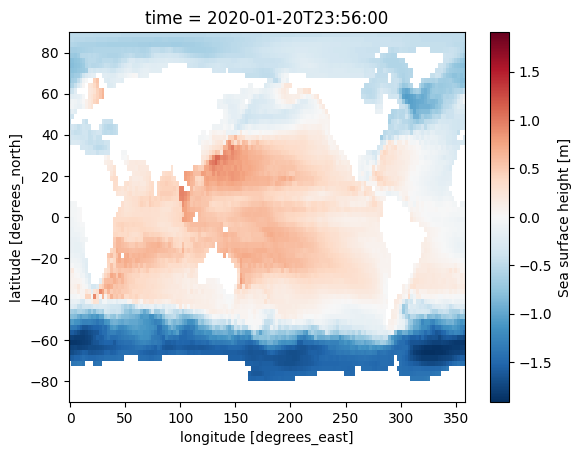

In [17]:
sstr.plot()

### Example 4: Original 3D FESOM data - further interpolation

The regridder can also deal with 3D masked fields, thanks to new functionality in *smmregrid*.

This functionality now works with any input source, even if it contains multiple vertical coordinates.
Let's show this loading original 3D FESOM data. 

Please be advised that calculation of the weights (which will be done only the first time, if weights are not available) is a very memory-intensive task (a full node on levante with 256GB memory may be needed for 3D FESOM data from the tco2559 experiment). Using 16 cores (by default) generation of weights for FESOM, with two vertical coordinates, may take about 40 minutes, so please be patient. 

The weights for the "r100" grid (1° regular grid) case have been precomputed on levante.

In [18]:
from aqua import Reader
reader = Reader(model="FESOM", exp="tco2559-ng5-cycle3", source="3D_daily_native", regrid="r100")

The reader loaded the precomputed 3D weights (pointing to `weights_FESOM_tco2559-ng5_original_3d_ycon_r100_l3d.nc` for example) and organizes them in a dictionary according to the vertical coordinate ("2d" for 2D variables)

In [19]:
reader.weights

{'nz': <xarray.Dataset>
 Dimensions:              (nz: 70, src_grid_rank: 1, dst_grid_rank: 2,
                           src_grid_size: 7402886, dst_grid_size: 64800,
                           src_grid_corners: 16, dst_grid_corners: 4,
                           num_links: 8790493, num_wgts: 1)
 Coordinates:
   * nz                   (nz) int64 0 1 2 3 4 5 6 7 ... 62 63 64 65 66 67 68 69
 Dimensions without coordinates: src_grid_rank, dst_grid_rank, src_grid_size,
                                 dst_grid_size, src_grid_corners,
                                 dst_grid_corners, num_links, num_wgts
 Data variables: (12/21)
     link_length          (nz) int64 dask.array<chunksize=(70,), meta=np.ndarray>
     src_grid_dims        (src_grid_rank) int32 dask.array<chunksize=(1,), meta=np.ndarray>
     dst_grid_dims        (dst_grid_rank) int32 dask.array<chunksize=(2,), meta=np.ndarray>
     src_grid_center_lat  (src_grid_size) float64 dask.array<chunksize=(7402886,), meta=np.ndarray>
 

We can now retrieve the data

In [20]:
data = reader.retrieve()
data

2023-11-30 16:06:10 :: eccodes :: WARNING  -> ShortName sst have multiple grib codes associated: ['34', '151159']
2023-11-30 16:06:10 :: eccodes :: WARNING  -> AQUA will take the first so that sst -> 34, please set up a correct fix if this does not look right
2023-11-30 16:06:10 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-30 16:06:10 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-11-30 16:06:10 :: eccodes :: WARNING  -> ShortName wo have multiple grib codes associated: ['262507', '151133']
2023-11-30 16:06:10 :: eccodes :: WARNING  -> AQUA will take the first so that wo -> 262507, please set up a correct fix if this does not look right
2023-11-30 16:06:10 :: eccodes :: WARNING  -> ShortName so have multiple grib codes associated: ['262500', '151130']
2023-11-30 16:06:10 :: eccodes :: WARNING  -> AQUA will take the first so that so -> 262500, p

<xarray.Dataset>
Dimensions:  (nz: 70, time: 1808, nod2: 7402886, nz1: 69)
Coordinates:
  * nz       (nz) float64 0.0 5.0 10.0 15.0 ... 5.4e+03 5.65e+03 6e+03 6.35e+03
  * time     (time) datetime64[ns] 2020-01-20T23:56:00 ... 2024-12-31T23:56:00
  * nz1      (nz1) float64 2.5 7.5 12.5 17.5 ... 5.525e+03 5.825e+03 6.175e+03
Dimensions without coordinates: nod2
Data variables:
    vdf      (time, nz, nod2) float32 dask.array<chunksize=(1, 70, 7402886), meta=np.ndarray>
    so       (time, nz1, nod2) float32 dask.array<chunksize=(1, 69, 7402886), meta=np.ndarray>
    ocpt     (time, nz1, nod2) float32 dask.array<chunksize=(1, 69, 7402886), meta=np.ndarray>
    wo       (time, nz, nod2) float32 dask.array<chunksize=(1, 70, 7402886), meta=np.ndarray>
Attributes: (12/18)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       dfbf523
    FESOM_MeshPath:                      /work/bm1235/ifs-inputs_nxg_c3/fesom...
    FESOM_mesh_representative_checksum:  
    FESOM_ClimateDataPath:               /work/bm1235/ifs-inputs_nxg_c3/fesom...
    ...                                  ...
    FESOM_whichEVP:                      1
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    -1
    FESOM_autorotate_back_to_geo:        -1
    history:                             2023-11-30 16:06:10 retrieved by AQU...

and regrid them

In [21]:
s0 = data.so.isel(time=0)
s0r = reader.regrid(s0)

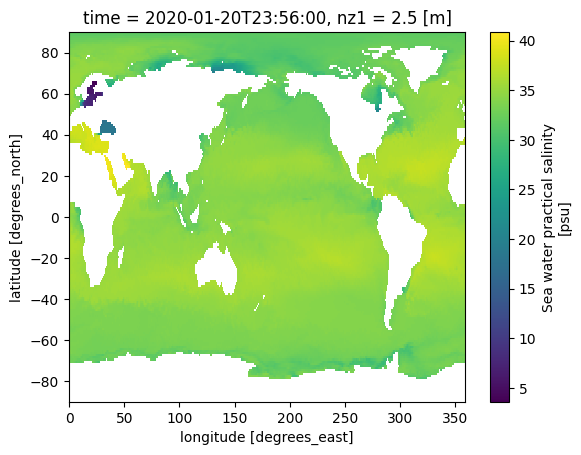

In [22]:
s0r.isel(nz1=0).plot()

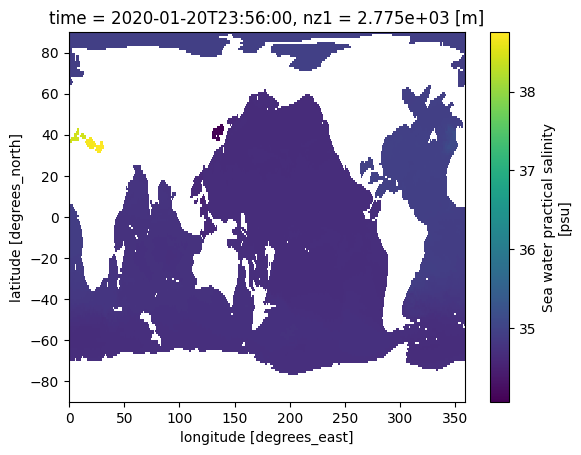

In [23]:
s0r.isel(nz1=55).plot()

We can also ask the regridder to regrid all variables at once upon retrieval (in this case the data include variables depending on two different vertical coordinates):

2023-11-30 16:06:19 :: eccodes :: WARNING  -> ShortName sst have multiple grib codes associated: ['34', '151159']
2023-11-30 16:06:19 :: eccodes :: WARNING  -> AQUA will take the first so that sst -> 34, please set up a correct fix if this does not look right
2023-11-30 16:06:19 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-30 16:06:19 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-11-30 16:06:19 :: eccodes :: WARNING  -> ShortName wo have multiple grib codes associated: ['262507', '151133']
2023-11-30 16:06:19 :: eccodes :: WARNING  -> AQUA will take the first so that wo -> 262507, please set up a correct fix if this does not look right
2023-11-30 16:06:19 :: eccodes :: WARNING  -> ShortName so have multiple grib codes associated: ['262500', '151130']
2023-11-30 16:06:19 :: eccodes :: WARNING  -> AQUA will take the first so that so -> 262500, p

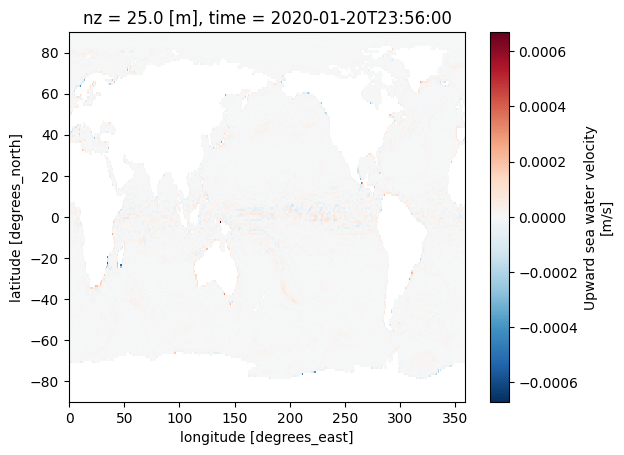

In [24]:
data = reader.retrieve()
data = reader.regrid(data)
w0 = data.wo.isel(time=0)
w0.isel(nz=5).plot()

### Example 5: ICON on HEALPix

We can also regrid ICON Healpix data from NextGEMS Cycle 3. Here an example for three different zoom level (i.e. grid hierarchy, with 0 as the coarser)

2023-11-30 16:07:30 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-11-30 16:07:30 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right
2023-11-30 16:07:30 :: eccodes :: WARNING  -> ShortName vo have multiple grib codes associated: ['262503', '138']
2023-11-30 16:07:30 :: eccodes :: WARNING  -> AQUA will take the first so that vo -> 262503, please set up a correct fix if this does not look right
2023-11-30 16:07:30 :: Reader :: ERROR    -> Variable conc has no units!
2023-11-30 16:07:30 :: Reader :: ERROR    -> Variable heat_content_seaice has no units!
2023-11-30 16:07:30 :: Reader :: ERROR    -> Variable heat_content_snow has no units!
2023-11-30 16:07:30 :: Reader :: ERROR    -> Variable heat_content_total has no units!
2023-11-30 16:07:30 :: Reader :: ERROR    -> Variable hydro_canopy_cond_limited_box has no units!
2023-11-30 16:07:30 :: Reader :

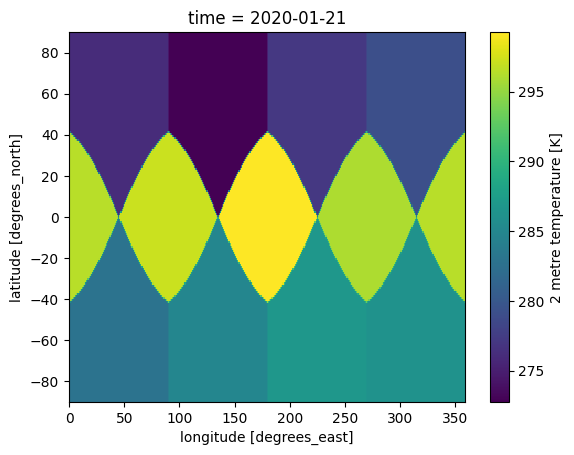

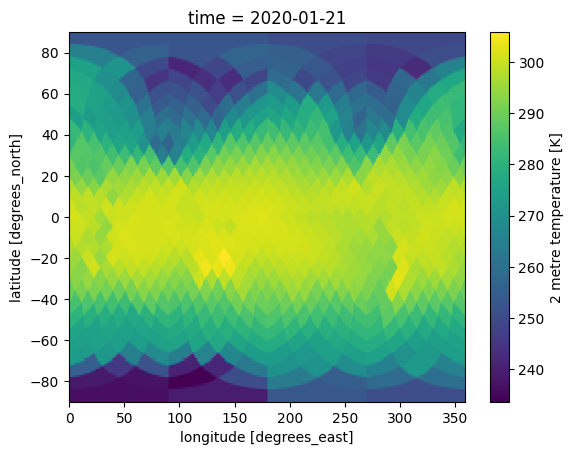

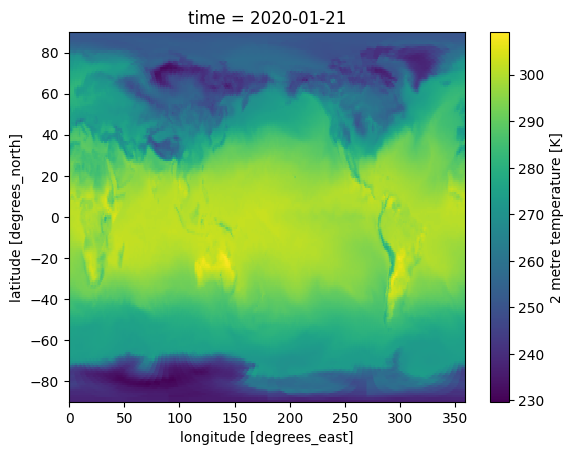

In [25]:
import matplotlib.pyplot as plt
from aqua import Reader

for zoom in [0, 3, 6]:
    reader = Reader(model="ICON", exp="ngc3028", source="P1D", zoom=zoom, regrid="r100")
    data = reader.retrieve()
    tas = reader.regrid(data['2t'][0])
    plt.figure()
    tas.plot()

### Example 6: 3D ICON data (NextGEMS cycle 3, HEALPix)

We load nextgems data on a HEALPix grid at zoom level 6 regridding already when reading the data. The weights will be computed only the first time this is called (if they are not already available in the grids directory).
We retrieve three variables which are 2D (zos) or 3D and living on different vertical levels (tke, to).

In [1]:
from aqua import Reader
zoom=6

reader = Reader(model="ICON", exp="ngc3028", source="P1D", zoom=6, regrid="r100", loglevel='debug')
data1 = reader.retrieve(var=["to", "tke", "2t", "zos"])
data = reader.regrid(data1)

2023-11-30 16:27:53 :: Reader :: INFO     -> No specific fixes available for model ICON, experiment ngc3028, source P1D: checking for model default...
2023-11-30 16:27:53 :: Reader :: INFO     -> Using default for model ICON, experiment ngc3028
2023-11-30 16:27:53 :: Reader :: INFO     -> For source P1D, method for fixes is: merge
2023-11-30 16:27:53 :: Reader :: DEBUG    -> Merging default fixes with source-specific fixes
2023-11-30 16:27:53 :: Reader :: DEBUG    -> Final fixes are: {'data_model': False, 'delete': ['hfls', 'hfss', 'rlus', 'rlut', 'rsus', 'rsdt', 'rsut'], 'vars': {'iews': {'source': 'tauu', 'grib': True}, 'inss': {'source': 'tauv', 'grib': True}, 'skt': {'source': 'ts', 'grib': True}, 'sp': {'source': 'ps', 'grib': True}, 'msl': {'source': 'pres_msl', 'src_units': 'Pa', 'grib': True}, '10si': {'source': 'sfcwind', 'grib': True}, 'ci': {'source': 'sic', 'src_units': '1', 'grib': True, 'units': '1'}, 'sithick': {'source': 'sit', 'grib': True}, '2t': {'source': 'tas', 'gr

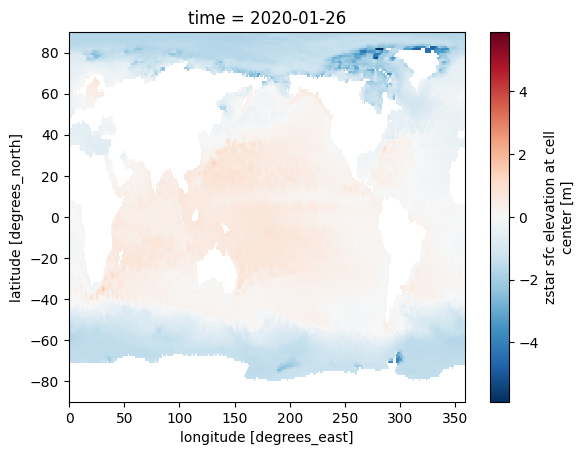

In [2]:
data['zos'][5,:,:].plot()

3D ocean data have been correctly masked:

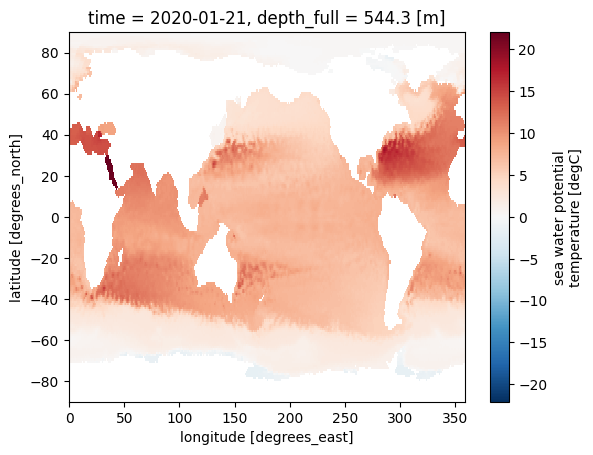

In [3]:
data.to.isel(depth_full=60).isel(time=0).plot()

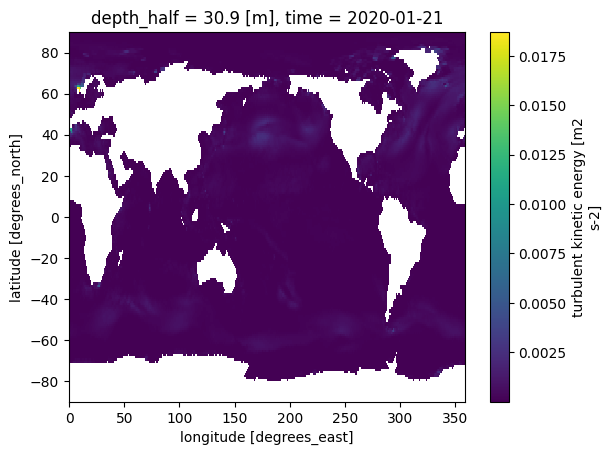

In [4]:
data.tke.isel(depth_half=12).isel(time=0).plot()

while atmospheric variables have not been masked:

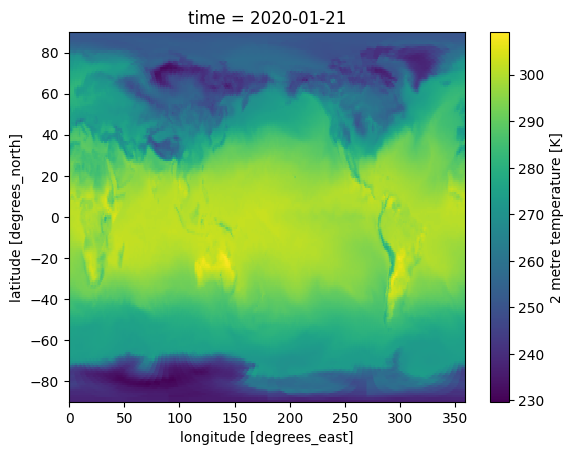

In [5]:
data["2t"].isel(time=0).plot()

The Reader can distinguish ICON atmospheric from ocean components checking for the presence of the "component: ocean" attribute (actually any attribute could be used, this is defined in regrid.yaml)